*Copyright (C) 2023 Battelle Memorial Institute*<br>
*SPDX-License-Identifier: BSD-2-Clause*<br>
*See: https://spdx.org/licenses/*

## Sparse Coding with LCA in Lava

This tutorial covers how to use the Locally Competative Algorithm (LCA) Solver developed in Lava to perform sparse coding.

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")

## The Locally Competative Algorithm (LCA)

Given a dictionary $\Phi$ and input vector $s$, sparse coding aims to find a vector $a$ which is a 
sparse representation of $s$ by minimizing the following energy function:
$$E(s,\Phi, a)=\min\limits_{ \{a, \, \Phi \} } \left[  \, \frac{1}{2}  ||  s - \Phi  a ||^2 +	\lambda || a ||_1\right] $$

LCA finds a local minimum of this cost function by introducing the dynamical variables (membrane potentials) $u$ such that the output $a$ is given by a soft-threshold transfer function, whose threshold is given by the sparsity tradeoff paramter:

$$
     a = T_\lambda(u) = 
    \begin{cases} 
      u -  \lambda,  & u > \lambda \\
      0,  & \textrm{otherwise}
   \end{cases}
$$


The cost function is then minimized by taking the gradient of the cost function with respect to $a$ and solving the resulting set of coupled differential equations for the membrane potentials $u$: 

$$
\dot{u} \propto -\dfrac{\partial E}{\partial a} = -u + \Phi^T s - \Phi T_\lambda(u)\ +  T_\lambda(u).
$$


We can split this update rule into two models: one layer and two layer LCA, shown below.

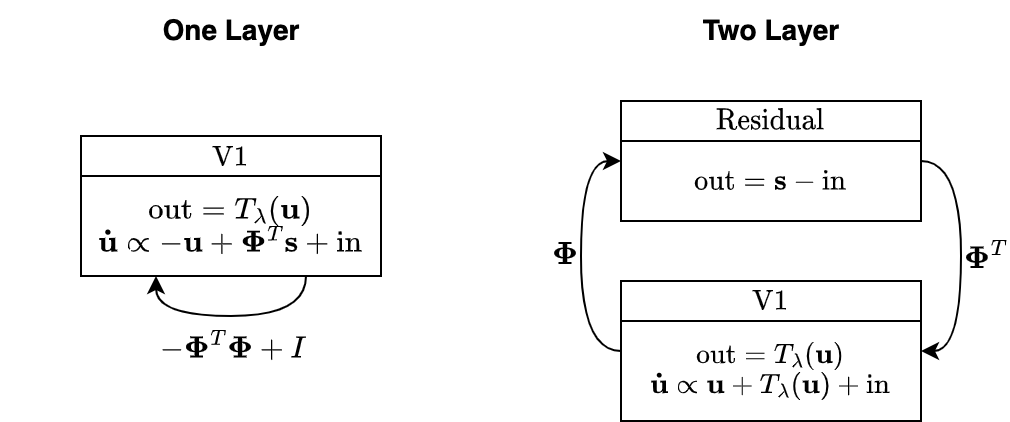

## Example: Sparse Coding MNIST

### General Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Loading MNIST
We first load the data we want to sparse code:

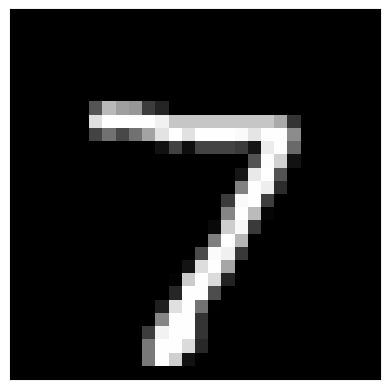

In [2]:
from lava.utils.dataloader.mnist import MnistDataset

dataset = MnistDataset()

MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

def normalize_image(image):
    return ((image / 255) - MNIST_MEAN) / MNIST_STD

def denormalize_image(image):
    return ((image * MNIST_STD) + MNIST_MEAN) * 255

# Pick an image to reconstruct. Note the image is already flattened
image = dataset.test_images[0]

# Display the image for reference
plt.xticks([])
plt.yticks([])
plt.imshow(image.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
plt.show()

### Loading the dictionary
Next we load the dictionary used to reconstruct an image. This dictionary was
pretrained on MNIST using [SPORCO](https://sporco.readthedocs.io/en/latest/overview.html).
Each of the 784 rows represent an element. 

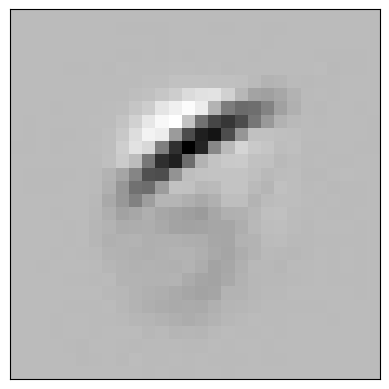

In [3]:
# Dictionary is 784x784, where each row is a dictionary element.
dictionary = np.load(os.path.join('.', "mnist_pretrained_dictionary.npy"))

# Display a single dictionary element for reference
plt.xticks([])
plt.yticks([])
plt.imshow(dictionary[128].reshape(28, 28), cmap='gray')
plt.show()

#### Helper function to evaluate sparse coding performance

In [4]:
def plot_results(dictionary, sparse_coding, image):
    reconstruction = denormalize_image((dictionary.T @ sparse_coding).squeeze())
    mse = ((reconstruction - image)**2).mean()
    psnr = 10 * np.log10(255**2 / mse)
    sparsity = 1 - (sparse_coding != 0).sum() / sparse_coding.size

    _, axs = plt.subplots(ncols=2)

    axs[0].set(title="Original", xticks=[], yticks=[])
    axs[0].imshow(image.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    axs[1].set(title="Reconstruction", xticks=[], yticks=[])
    axs[1].imshow(reconstruction.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    plt.show()
    print('Reconstruction PSNR: {:.2f}dB'.format(psnr))
    print('Sparsity: {:.2f}%'.format(sparsity * 100))

#### Import the models

In [5]:
from lava.proc.io import sink
from lava.lib.optimization.solvers.lca.process import LCA1Layer, LCA2Layer
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

# Floating Point

The floating point implementations are often a good starting point as they can
inform the fixed point design.

#### Define LCA parameters

In [6]:
# Time constant
tau = 2**-7
# Threshold Lambda
threshold = 0.1
# Iterations to run
iterations = 1024

### 1 Layer

The one layer implementation has some preprocessing on the inputs:

In [7]:
from lava.lib.optimization.solvers.lca.util import get_1_layer_weights, get_1_layer_bias

weights = get_1_layer_weights(dictionary, tau)
bias = get_1_layer_bias(dictionary, tau, normalize_image(image))

We can then construct the model, using a RingBuffer to capture the output reconstruction. 

In [8]:
one_layer_float = LCA1Layer(weights, bias, threshold=threshold, tau=tau)
v1_output = sink.RingBuffer(shape=one_layer_float.v1.shape, buffer=1)

one_layer_float.v1.connect(v1_output.a_in)

Now we run the model, retrieve the sparse coding from the buffer, and plot the reconstruction.

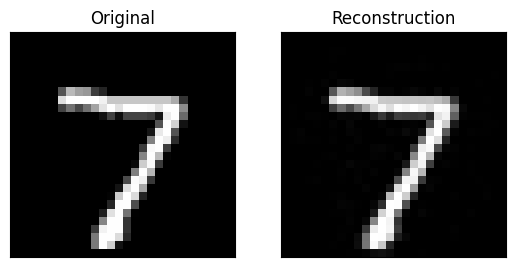

Reconstruction PSNR: 37.12dB
Sparsity: 75.38%


In [9]:
run_config = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)

with one_layer_float:
    one_layer_float.run(condition=RunSteps(num_steps=iterations), run_cfg=run_config)
    sparse_coding_1_layer_float = v1_output.data.get()

plot_results(dictionary, sparse_coding_1_layer_float, image)

### 2 Layer

Constructing the two layer model:

In [10]:
two_layer_float = LCA2Layer(weights=dictionary, input_vec=normalize_image(image),
                            threshold=threshold, tau=tau, spike_height=0)
v1_output = sink.RingBuffer(shape=two_layer_float.v1.shape, buffer=1)

two_layer_float.v1.connect(v1_output.a_in)

Running the model and plotting the reconstruction:

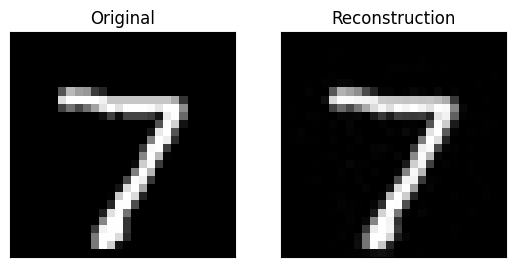

Reconstruction PSNR: 37.12dB
Sparsity: 75.51%


In [11]:
run_config = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)

with two_layer_float:
    two_layer_float.run(condition=RunSteps(num_steps=iterations), run_cfg=run_config)
    sparse_coding_2_layer_float = v1_output.data.get()

plot_results(dictionary, sparse_coding_2_layer_float, image)

# Fixed Point

The input to the fixed point implementation must be scaled to an integer value.
This scaling also determines the scaling of the output sparse representation and
threshold. The optimial scaling can be determined using a known sparse representation
from the floating point model:

In [12]:
from lava.lib.optimization.solvers.lca.util import get_fixed_pt_scale

# The scale is the largest power of 2 such that the sparse_coding * scale does
# not exceed 2**24
scale = get_fixed_pt_scale(sparse_coding_1_layer_float)

threshold_fixed = int(0.1 * scale)

Alternatively it can be estimated using an input and the dictionary. Underestimating the scale is better than overestimating, as too large of a scale can restrict the range of the sparse representation:

In [13]:
estimated_coding = normalize_image(image) @ dictionary.T
estimate_scale = get_fixed_pt_scale(estimated_coding)

print("Optimal", scale)
print("Estimate", estimate_scale)

Optimal 2097152.0
Estimate 1048576.0


### 1 Layer

Calculating the scaled weights and bias

In [14]:
weights = get_1_layer_weights(dictionary, tau)
# Scaling the weights to 0-255 * 2**weight_exp
weights_exp = np.frexp(np.max(np.abs(weights)))[1] - 8
weights = (weights * 2**-weights_exp).astype(np.int32)

bias = (get_1_layer_bias(dictionary, tau, normalize_image(image)) * scale).astype(np.int32)

Defining the model:

In [15]:
one_layer_fixed = LCA1Layer(weights=weights, weights_exp=weights_exp, bias=bias,
                            threshold=threshold_fixed, tau=1, tau_exp=-7)
# Note tau is split into an integer and exponent form.
v1_output = sink.RingBuffer(shape=one_layer_fixed.v1.shape, buffer=1)

one_layer_fixed.v1.connect(v1_output.a_in)

Running the model and displaying the reconstruction:

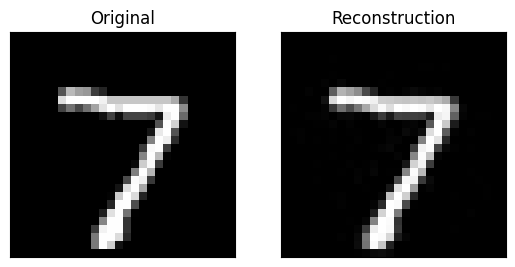

Reconstruction PSNR: 37.80dB
Sparsity: 71.05%


In [16]:
run_config = Loihi1SimCfg(select_tag='fixed_pt', select_sub_proc_model=True)

with one_layer_fixed:
    one_layer_fixed.run(condition=RunSteps(num_steps=iterations), run_cfg=run_config)
    sparse_coding = v1_output.data.get() / scale

plot_results(dictionary, sparse_coding, image)

### 2 Layer

Scaling the input image and weights:

In [17]:
# Scaling the weights to 0-255 * 2**weight_exp
weights_exp = np.frexp(np.max(np.abs(dictionary)))[1] - 8
weights = (dictionary * 2**-weights_exp).astype(np.int32)

scaled_image = (normalize_image(image) * scale).astype(np.int32)

Defining the model:

In [18]:
two_layer_fixed = LCA2Layer(weights=weights, weights_exp=weights_exp,
                            input_vec=scaled_image, threshold=threshold_fixed, tau=1,
                            tau_exp=-7, spike_height=0)
v1_output = sink.RingBuffer(shape=two_layer_fixed.v1.shape, buffer=1)

two_layer_fixed.v1.connect(v1_output.a_in)

run_config = Loihi1SimCfg(select_tag='fixed_pt', select_sub_proc_model=True)

Running the model and displaying the reconstruction:

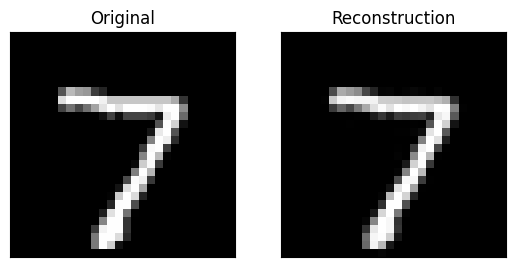

Reconstruction PSNR: 27.31dB
Sparsity: 73.85%


In [19]:
with two_layer_fixed:
    two_layer_fixed.run(condition=RunSteps(num_steps=iterations), run_cfg=run_config)
    sparse_coding = v1_output.data.get() / scale

plot_results(dictionary, sparse_coding, image)

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the LCA solver and the optimization toolbox in Lava in general. 
